- This notebook is for training the model for predicting the column "lights" while it is considered as categorical data, with "epochs = 200, batch_size = 2048".

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rn
import tensorflow as tf

from keras import backend as K
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import load_model
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
# prepare the functions for evaluating the model
def mse(ar1, ar2):
    return ((ar1 - ar2) ** 2).mean()

def rmse(ar1, ar2):
    return np.sqrt(mse(ar1, ar2))

In [3]:
# make the results reproducible
os.environ["PYTHONHASHSEED"] = '0'
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [4]:
# loading and preprocessing data
energydata_complete = pd.read_csv("energydata_complete.csv").iloc[:, 1:]

energydata_complete = energydata_complete.drop(['Appliances'], axis=1)

Y = energydata_complete.iloc[:, 0].values

labelencoder_Y_1 = LabelEncoder()
Y_labled = labelencoder_Y_1.fit_transform(Y)

onehotencoder = OneHotEncoder(categorical_features = [0])
Y_onehot = onehotencoder.fit_transform(Y_labled.reshape(Y_labled.shape[0], 1)).toarray()
print(Y_onehot)

Y_columnnames = []
for i in range(Y_onehot.shape[1]):
    if i < 10:
        Y_columnnames.append("Y1_0{0}".format(i))
    else:
        Y_columnnames.append("Y1_{0}".format(i))

Y_onehot = pd.DataFrame(Y_onehot, columns = Y_columnnames)

sc = MinMaxScaler(feature_range = (0, 1))
variables_scaled = pd.DataFrame(sc.fit_transform(energydata_complete.iloc[:, 1:]), columns = list(energydata_complete.iloc[:, 1:].columns))
print(variables_scaled.head())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
        T1      RH_1        T2      RH_2        T3      RH_3        T4  \
0  0.32735  0.566187  0.225345  0.684038  0.215188  0.746066  0.351351   
1  0.32735  0.541326  0.225345  0.682140  0.215188  0.748871  0.351351   
2  0.32735  0.530502  0.225345  0.679445  0.215188  0.755569  0.344745   
3  0.32735  0.524080  0.225345  0.678414  0.215188  0.758685  0.341441   
4  0.32735  0.531419  0.225345  0.676727  0.215188  0.758685  0.341441   

       RH_4        T5      RH_5    ...           T9      RH_9     T_out  \
0  0.764262  0.175506  0.381691    ...     0.223032  0.677290  0.372990   
1  0.782437  0.175506  0.381691    ...     0.226500  0.678532  0.369239   
2  0.778062  0.175506  0.380037    ...     0.219563  0.676049  0.365488   
3  0.770949  0.175506  0.380037    ...     0.219563  0.671909  0.361736   
4  0.762697  0.178691  0

d:\programfilesnospace\miniconda3\envs\py365-tfgpu\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
d:\programfilesnospace\miniconda3\envs\py365-tfgpu\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [5]:
# separate the data into training set and testing set
X_train_scaled = variables_scaled.iloc[:round(np.shape(variables_scaled)[0] * 0.8), :]
Y_train_encoded = Y_onehot.iloc[:round(np.shape(Y_onehot)[0] * 0.8), :]

X_test_scaled = variables_scaled.iloc[round(np.shape(variables_scaled)[0] * 0.8):, :]
Y_test_encoded = Y_onehot.iloc[round(np.shape(Y_onehot)[0] * 0.8):, :]

X_train_scaled = np.reshape(X_train_scaled.values, (X_train_scaled.values.shape[0], X_train_scaled.values.shape[1], 1))
X_test_scaled = np.reshape(X_test_scaled.values, (X_test_scaled.values.shape[0], X_test_scaled.values.shape[1], 1))

In [6]:
# Initialising the RNN
layers = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layers.add(LSTM(units = 16, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
layers.add(Dropout(0.2))

layers.add(Flatten())

# Adding the output layer
layers.add(Dense(Y_train_encoded.shape[1], activation='softmax'))

layers.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/200
15788/15788 [==============================] - 1s 67us/step - loss: 1.7645 - acc: 0.6027
Epoch 2/200
15788/15788 [==============================] - 0s 20us/step - loss: 1.1461 - acc: 0.7432
Epoch 3/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.9261 - acc: 0.7432
Epoch 4/200
15788/15788 [==============================] - 0s 21us/step - loss: 0.8885 - acc: 0.7432
Epoch 5/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.8764 - acc: 0.7432
Epoch 6/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.8733 - acc: 0.7432
Epoch 7/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.8661 - acc: 0.7432
Epoch 8/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.8664 - acc: 0.7432
Epoch 9/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.8629 - acc: 0.7432
Epoch 10/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.8621 - a

15788/15788 [==============================] - 0s 20us/step - loss: 0.8057 - acc: 0.7432
Epoch 82/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.8021 - acc: 0.7432
Epoch 83/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.8014 - acc: 0.7437
Epoch 84/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.8044 - acc: 0.7425
Epoch 85/200
15788/15788 [==============================] - 0s 23us/step - loss: 0.8005 - acc: 0.7442
Epoch 86/200
15788/15788 [==============================] - 0s 24us/step - loss: 0.8000 - acc: 0.7433
Epoch 87/200
15788/15788 [==============================] - 0s 23us/step - loss: 0.8019 - acc: 0.7435
Epoch 88/200
15788/15788 [==============================] - 0s 22us/step - loss: 0.7976 - acc: 0.7433
Epoch 89/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7969 - acc: 0.7442
Epoch 90/200
15788/15788 [==============================] - 0s 21us/step - loss: 0.7977 - acc: 

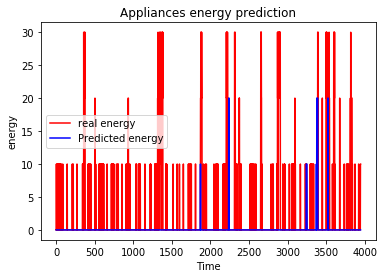

In [7]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 200, batch_size = 2048)

# layers.save('layers2_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers2_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

Epoch 1/200
15788/15788 [==============================] - 1s 49us/step - loss: 0.7429 - acc: 0.7525
Epoch 2/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7418 - acc: 0.7528
Epoch 3/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7411 - acc: 0.7540
Epoch 4/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7407 - acc: 0.7536
Epoch 5/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7424 - acc: 0.7536
Epoch 6/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7423 - acc: 0.7530
Epoch 7/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7425 - acc: 0.7532
Epoch 8/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7407 - acc: 0.7549
Epoch 9/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7407 - acc: 0.7541
Epoch 10/200
15788/15788 [==============================] - 0s 21us/step - loss: 0.7389 - a

15788/15788 [==============================] - 0s 20us/step - loss: 0.7041 - acc: 0.7621
Epoch 161/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7050 - acc: 0.7607
Epoch 162/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7067 - acc: 0.7603
Epoch 163/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7021 - acc: 0.7620
Epoch 164/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7030 - acc: 0.7633
Epoch 165/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7027 - acc: 0.7618
Epoch 166/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7045 - acc: 0.7606
Epoch 167/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7053 - acc: 0.7615
Epoch 168/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7013 - acc: 0.7626
Epoch 169/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.705

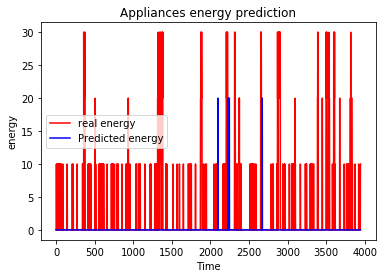

In [8]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 200, batch_size = 2048)

# layers.save('layers2_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers2_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

Epoch 1/200
15788/15788 [==============================] - 1s 49us/step - loss: 0.6991 - acc: 0.7615
Epoch 2/200
15788/15788 [==============================] - 0s 21us/step - loss: 0.6998 - acc: 0.7621
Epoch 3/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7020 - acc: 0.7608
Epoch 4/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6983 - acc: 0.7644
Epoch 5/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6985 - acc: 0.7628
Epoch 6/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6994 - acc: 0.7626: 0s - loss: 0.7006 - acc: 0.76
Epoch 7/200
15788/15788 [==============================] - 0s 21us/step - loss: 0.7008 - acc: 0.7624
Epoch 8/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6979 - acc: 0.7637
Epoch 9/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.7019 - acc: 0.7618
Epoch 10/200
15788/15788 [==============================] - 

15788/15788 [==============================] - 0s 28us/step - loss: 0.6870 - acc: 0.7657
Epoch 160/200
15788/15788 [==============================] - 0s 25us/step - loss: 0.6847 - acc: 0.7665
Epoch 161/200
15788/15788 [==============================] - 0s 26us/step - loss: 0.6867 - acc: 0.7660
Epoch 162/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6879 - acc: 0.7657
Epoch 163/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6868 - acc: 0.7663
Epoch 164/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6821 - acc: 0.7677
Epoch 165/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6840 - acc: 0.7654
Epoch 166/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6868 - acc: 0.7662
Epoch 167/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6825 - acc: 0.7659
Epoch 168/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.687

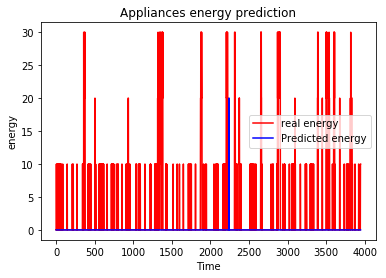

In [9]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 200, batch_size = 2048)

# layers.save('layers2_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers2_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

Epoch 1/200
15788/15788 [==============================] - 1s 49us/step - loss: 0.6827 - acc: 0.7670
Epoch 2/200
15788/15788 [==============================] - 0s 21us/step - loss: 0.6830 - acc: 0.7653
Epoch 3/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6819 - acc: 0.7666
Epoch 4/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6816 - acc: 0.7651
Epoch 5/200
15788/15788 [==============================] - 0s 21us/step - loss: 0.6812 - acc: 0.7653
Epoch 6/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6805 - acc: 0.7677
Epoch 7/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6832 - acc: 0.7658
Epoch 8/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6817 - acc: 0.7673
Epoch 9/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6801 - acc: 0.7667
Epoch 10/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6812 - a

15788/15788 [==============================] - 0s 20us/step - loss: 0.6664 - acc: 0.7704
Epoch 161/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6686 - acc: 0.7694
Epoch 162/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6684 - acc: 0.7693
Epoch 163/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6664 - acc: 0.7689
Epoch 164/200
15788/15788 [==============================] - 0s 23us/step - loss: 0.6651 - acc: 0.7714
Epoch 165/200
15788/15788 [==============================] - 0s 24us/step - loss: 0.6683 - acc: 0.7679
Epoch 166/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6688 - acc: 0.7681
Epoch 167/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6659 - acc: 0.7705
Epoch 168/200
15788/15788 [==============================] - 0s 20us/step - loss: 0.6701 - acc: 0.7693
Epoch 169/200
15788/15788 [==============================] - 0s 26us/step - loss: 0.665

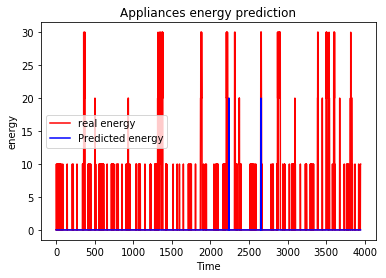

In [10]:
# all the following code will be executed manually for every iteration
layers.fit(X_train_scaled, Y_train_encoded, epochs = 200, batch_size = 2048)

# layers.save('layers2_1.h5')  # creates a HDF5 file 'my_model.h5'
# layers = load_model('layers2_1.h5')

predicted_energy = layers.predict(X_test_scaled)
accuracy = sum(np.argmax(predicted_energy, axis = 1) == np.argmax(Y_test_encoded.values, axis = 1)) / len(Y_test_encoded.values)
print("The accuracy(categorical) is: {0}".format(accuracy))

predicted_energy_inversed = labelencoder_Y_1.inverse_transform(np.argmax(predicted_energy, axis = 1))
predicted_mse = mse(predicted_energy_inversed, Y[round(np.shape(Y)[0] * 0.8):])
print("The mean squared error is: {0}".format(predicted_mse))

plt.plot(Y[round(np.shape(Y)[0] * 0.8):], color = 'red', label = 'real energy')
plt.plot(predicted_energy_inversed, color = 'blue', label = 'Predicted energy')
plt.title('Appliances energy prediction')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

- We ran 4 iterations, and with “epochs=200”, “batch_size=2048” for each. In the last iteration, we found that that the accuracy of categorical prediction reaches 89%, almost 90%, but from the graph we can see that most of the red lines, which indicate the real energy, is not overlain by the blue lines, which indicate the predicted value. It seems the accuracies are not consistent with the graphs.